# Exploration 1

What if we start small (let $\ell = m = n = 3$ so that we are tracking three variables with three neurons) and attempt to train the neural net to learn the Kalman filter? What does the loss look like over time for various initial values of $M$? What if we change the support of $M$?

In [30]:
# Import everything needed
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn
import tqdm

from hm_process import simulate_hm_process, plot_hm_process
from kalman import find_steady_state_kalman_parameters, steady_state_kalman_infer
from rnn import NeuralNet
from utils import calc_loss, mk_rand_matrix, mk_rand_matrix_envals

In [2]:
# Define some arbitrary parameters
n = 3
m = 3
A = np.diag([0.98, 0.96, 0.85])
x0 = np.array([100, 100, 100])
sigma_process = 10
Sigma_process = (sigma_process**2)*np.eye(n)
O = np.eye(3)
sigma_obs = 25
Sigma_obs = (sigma_obs**2)*np.eye(m)
rng = np.random.default_rng()
num_steps = 100

assert A.shape == (n, n)
assert x0.shape == (n,)
assert Sigma_process.shape == (n, n)
assert O.shape == (m, n)
assert Sigma_obs.shape == (m, m)

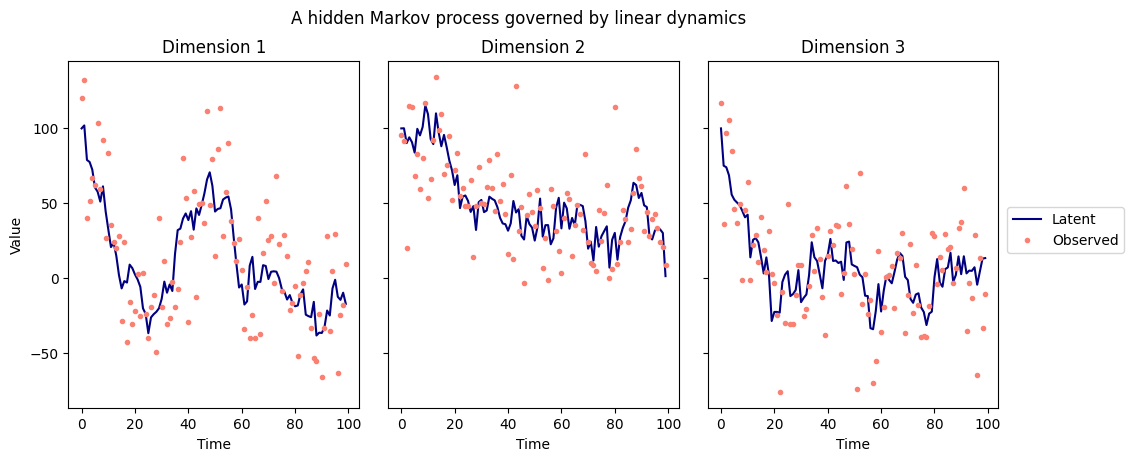

In [3]:
ts, xs, ys = simulate_hm_process(rng, n, m, A, x0, Sigma_process, O, Sigma_obs, num_steps)
plot_hm_process('A hidden Markov process governed by linear dynamics', ts, xs, ys)

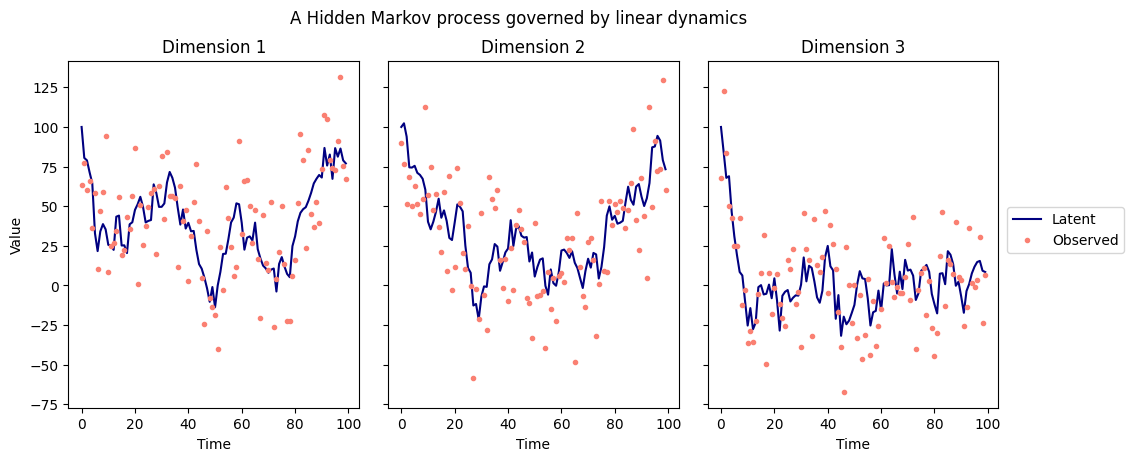

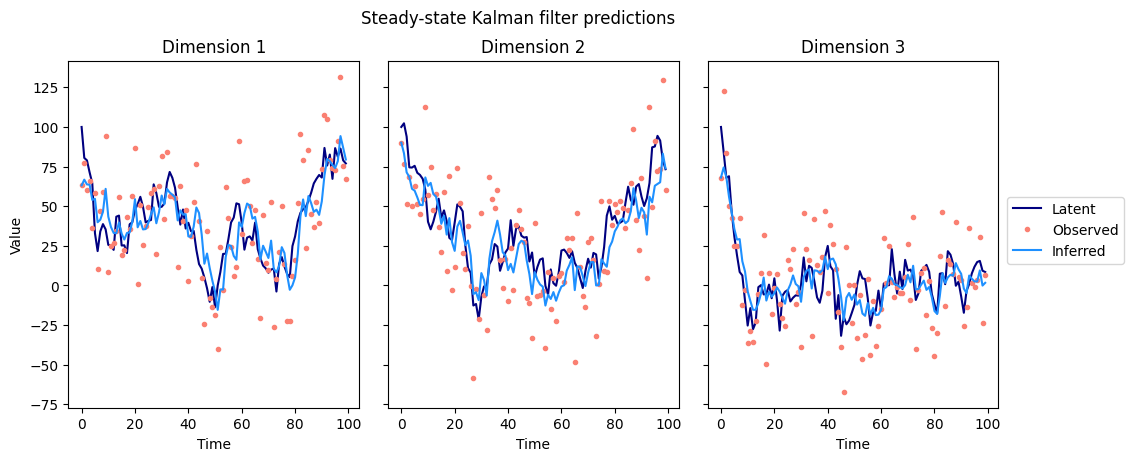

In [4]:
# Now, what if we try to predict what the latent states were based
# on the observations by using a steady-state Kalman filter, assuming
# we know the true values of A, Sigma_process, O, and Sigma_obs?
ts, xs, ys = simulate_hm_process(rng, n, m, A, x0, Sigma_process, O, Sigma_obs, num_steps)
xhats, _, _ = steady_state_kalman_infer(n, m, A, Sigma_process, O, Sigma_obs, ys)


# Now, let's plot it!
plot_hm_process('A Hidden Markov process governed by linear dynamics', ts, xs, ys)
plot_hm_process('Steady-state Kalman filter predictions', ts, xs, ys, xhats)

In [5]:
# Now, let's see if we can train a linear dynamical system to learn the Kalman filter.
A = mk_rand_matrix_envals(rng)
print(A)

_, K_infty = find_steady_state_kalman_parameters(n, m, A, Sigma_process, O, Sigma_obs)
print(K_infty)

[[ 0.88421878 -0.00678693  0.0053929 ]
 [-0.04031026  0.88516325  0.02535597]
 [ 0.02101864  0.00209045  0.86061797]]
[[ 0.27098644 -0.01013645  0.00577572]
 [-0.01013645  0.27264212  0.00522003]
 [ 0.00577572  0.00522003  0.26130284]]


In [6]:
# How well does the network do if I make the connectivity matrix
# closer or farther from the Kalman filter theory steady-state value?
def test_M_landscape():
    distances = []
    losses = []
    Mopt = A - K_infty@O@A
    for _ in range(15):
        M = mk_rand_matrix_envals(rng, envals=np.array([0.63, 0.63, 0.66]))
        for i in tqdm.tqdm(range(15)):
            c = i/20
            M2 = (1-c)*M + c*Mopt
            nn = NeuralNet(K_infty, M2, np.eye(3), x0)
            Ls = nn.batch_test(100, rng, n, m, A, x0, Sigma_process, O, Sigma_obs, num_steps)
            distances.append(calc_loss(M2, Mopt))
            losses.append(np.mean(Ls))
    return distances, losses

#distances, losses = test_M_landscape()

In [7]:
# Let's try plotting our results
#plt.scatter(np.sqrt(2*np.array(distances)), losses)
#plt.xlabel('Frobenius distance between M and the optimal value')
#plt.ylabel('Average loss (100 simulated trials)')
#plt.title('Loss vs Distance From Kalman Filter Theory')
#plt.show()

In [8]:
# What happens when we train the neural net on this task?
def compare_nn_kalman():
    nn = NeuralNet(0.1*mk_rand_matrix(rng), 0.1*mk_rand_matrix(rng), np.eye(3), x0)
    ts, xs, ys = simulate_hm_process(rng, n, m, A, x0, Sigma_process, O, Sigma_obs, num_steps)
    
    _, xhats = nn.forward(ys)
    plot_hm_process('Before training', ts, xs, ys, xhats)
    print('Loss', calc_loss(xhats, xs))
    print('M =', nn.M)
    print('K =', nn.K)
    
    losses = nn.train(np.array([1e-6]*20), 40, rng, n, m, A, x0, Sigma_process, O, Sigma_obs, num_steps)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Mean loss')
    plt.show()
    
    _, xhats = nn.forward(ys)
    plot_hm_process('After training', ts, xs, ys, xhats)
    print('Loss', calc_loss(xhats, xs))
    print('M =', nn.M)
    print('K =', nn.K)
    
    # How does it compare to a Kalman filter?
    xhats, _, K_infty = steady_state_kalman_infer(n, m, A, Sigma_process, O, Sigma_obs, ys)
    plot_hm_process('Kalman filter', ts, xs, ys, xhats)
    print('Loss', calc_loss(xhats, xs))
    print('M =', A - K_infty@O@A)
    print('K =', K_infty)

#compare_nn_kalman()

In [9]:
def mk_rand_mask(num_neurons=3):
    return np.random.randint(0,2,size=(num_neurons,num_neurons))

def test_masks():
    for _ in range(10):
        mask = mk_rand_mask()
        print(mask)
        nn = NeuralNet(0.1*mk_rand_matrix(rng), 0.1*mk_rand_matrix(rng), np.eye(3), x0, mask=mask)
        num_epochs, losses = nn.train_until_converge(1e-6, 200, 40, rng, n, m, A, x0, Sigma_process, O, Sigma_obs)
        plt.plot(losses)
        plt.xlabel('Epoch')
        plt.ylabel('Mean loss')
        plt.show()

#test_masks()

# Exploration 2

What's the right measure of distance between $(M,K)$ and $A$ that corresponds to the average loss at the task? We'll assume $O$ and $W$ are the identity.

In [10]:
# Let's start with 1 dimension for easy visualization
n = 1
m = 1
x0 = np.array([100])
sigma_process = 10
Sigma_process = (sigma_process**2)*np.eye(n)
O = np.array([[1]])
sigma_obs = 25
Sigma_obs = (sigma_obs**2)*np.eye(m)
rng = np.random.default_rng()
num_steps = 100
batch_size = 10
W = np.array([[1]])

assert x0.shape == (n,)
assert Sigma_process.shape == (n, n)
assert O.shape == (m, n)
assert Sigma_obs.shape == (m, m)

num_a_ticks = 5
num_ticks = 15
amk_range = 0.9
num_trials_per = 40

In [16]:
def find_nn_values_A_M_K(num_nns=5):
    mks = np.zeros((num_a_ticks,num_nns,2))

    for i, a_ in enumerate(np.linspace(-1*amk_range,amk_range,num_a_ticks)):
        A = np.array([[a_]])
        for j in tqdm.tqdm(range(num_nns)):
            nn = NeuralNet(0.1*mk_rand_matrix(rng, n=1), 0.1*mk_rand_matrix(rng, n=1), np.eye(1), x0)
            nn.train_until_converge(1e-6, 200, num_trials_per, rng, n, m, A, x0, Sigma_process, O,
                                    Sigma_obs, num_steps, print_loss=False, progress_bar=False)
            mks[i,j,0] = nn.M[0,0]
            mks[i,j,1] = nn.K[0,0]

    return mks


mks = find_nn_values_A_M_K()

100%|█████████████████████████████████████████████████████████| 5/5 [04:08<00:00, 49.74s/it]


In [17]:
def test_A_M_K_loss_landscape():
    losses = np.zeros((num_a_ticks,num_ticks,num_ticks))
    
    for i1, a_ in tqdm.tqdm(enumerate(np.linspace(-1*amk_range,amk_range,num_a_ticks)), total=num_a_ticks):
        for i2, m_ in enumerate(np.linspace(-1*amk_range,amk_range,num_ticks)):
            for i3, k_ in enumerate(np.linspace(-1*amk_range,amk_range,num_ticks)):
                A = np.array([[a_]])
                M = np.array([[m_]])
                K = np.array([[k_]])
                nn = NeuralNet(M, K, W, x0)
                Ls = nn.batch_test(batch_size, rng, n, m, A, x0, Sigma_process, O, Sigma_obs, num_steps)
                losses[i1,i2,i3] = np.mean(Ls)
    
    return losses

losses = test_A_M_K_loss_landscape()

100%|█████████████████████████████████████████████████████████| 5/5 [06:05<00:00, 73.16s/it]


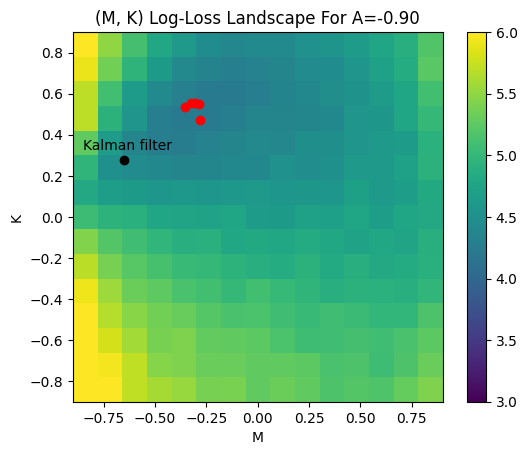

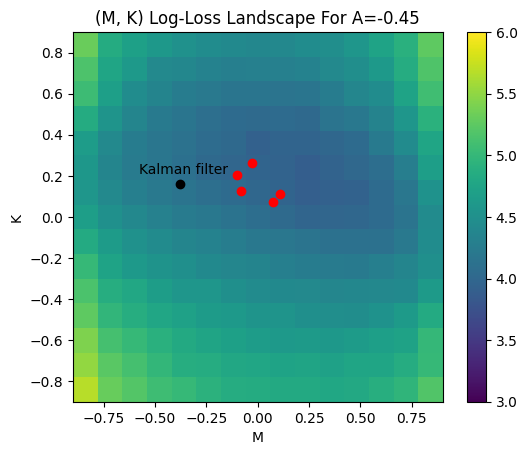

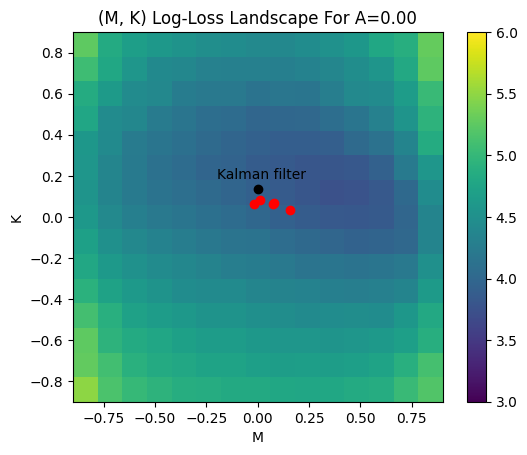

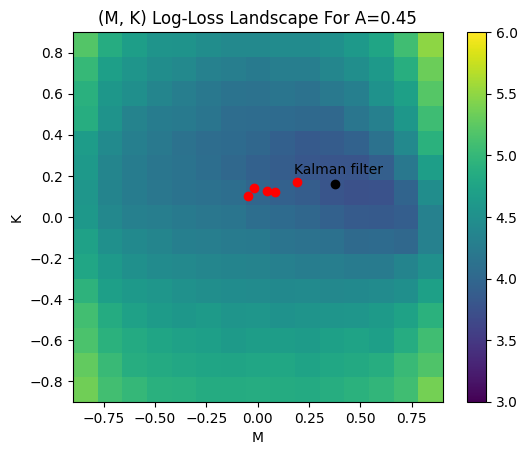

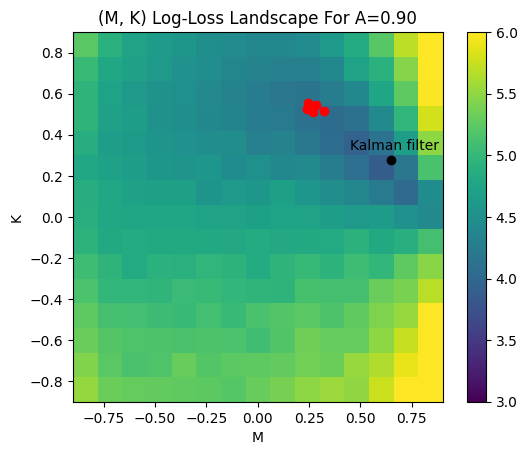

In [46]:
norm = matplotlib.colors.Normalize(3, 6)
for i1, a_ in enumerate(np.linspace(-1*amk_range,amk_range,num_a_ticks)):
    A = np.array([[a_]])
    _, K_infty = find_steady_state_kalman_parameters(n, m, A, Sigma_process, O, Sigma_obs)
    M_infty = A - K_infty@O@A

    # Loss landscape
    c = plt.imshow(np.log10(losses[i1].T), origin='lower', extent=(-1*amk_range,amk_range,-1*amk_range,amk_range), norm=norm)
    plt.xlabel('M')
    plt.ylabel('K')

    # Where does the Kalman filter fall?
    plt.plot(M_infty, K_infty, color='black', marker='o')
    plt.annotate('Kalman filter', (M_infty, K_infty), xytext=(M_infty-0.2,K_infty+0.05), color='black')

    # What about the RNNs?
    plt.scatter(mks[i1,:,0], mks[i1,:,1], color='red', marker='o')
    
    plt.title(f'(M, K) Log-Loss Landscape For A={a_:.2f}')
    plt.xlim(-1*amk_range, amk_range)
    plt.ylim(-1*amk_range, amk_range)
    plt.colorbar(c)
    plt.show()

Average loss 15355.32971633396


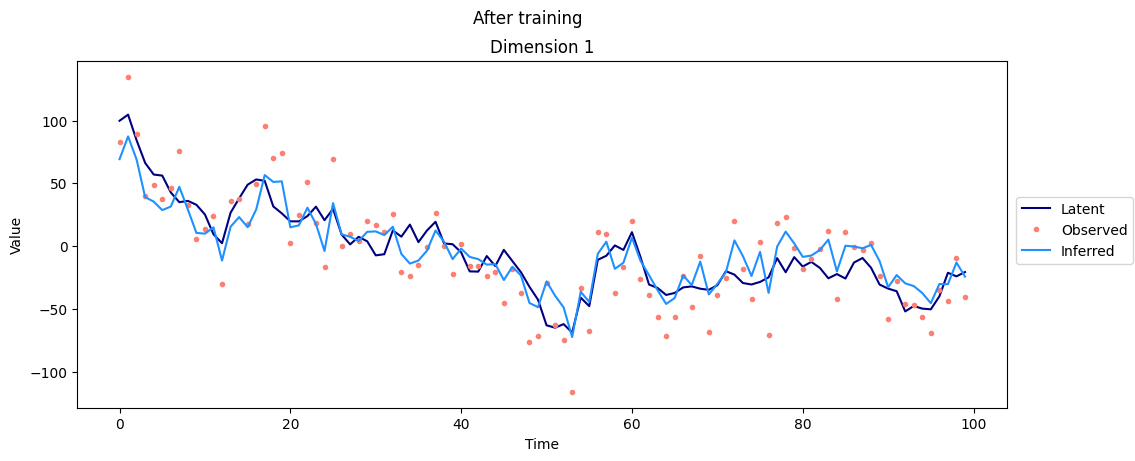

Loss 11643.966431762654
M = [[0.26713607]]
K = [[0.51132905]]
Average loss 8784.433907019544


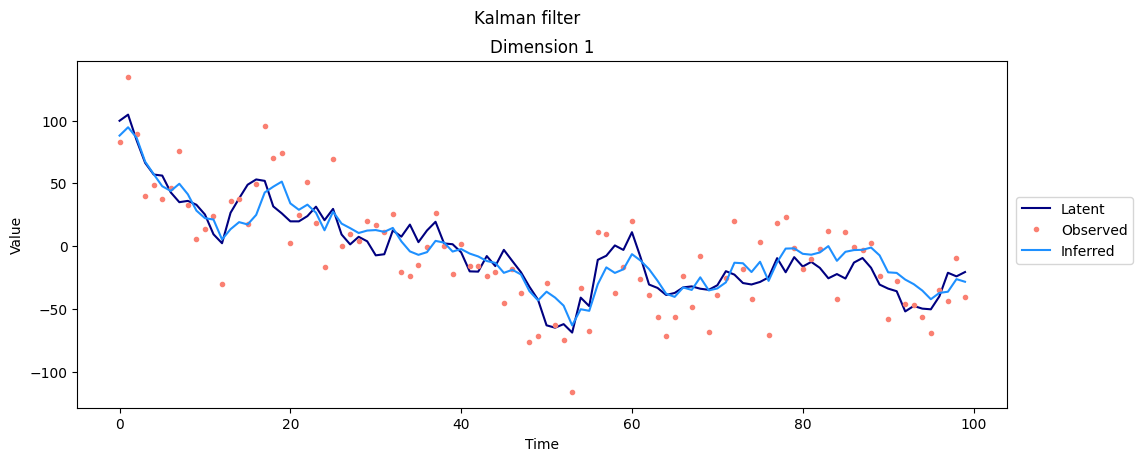

Loss 8240.578907683037
M = [[0.64968761]]
K = [[0.27812488]]


In [43]:
A = np.array([[0.90]])
ts, xs, ys = simulate_hm_process(rng, n, m, A, x0, Sigma_process, O, Sigma_obs, num_steps)

nn = NeuralNet(np.array([[mks[-1,0,0]]]), np.array([[mks[-1,0,1]]]), W, x0)
Ls = nn.batch_test(batch_size, rng, n, m, A, x0, Sigma_process, O, Sigma_obs, num_steps)
print('Average loss', np.mean(Ls))
_, xhats = nn.forward(ys)
plot_hm_process('After training', ts, xs, ys, xhats)
print('Loss', calc_loss(xhats, xs))
print('M =', nn.M)
print('K =', nn.K)

_, K_infty = find_steady_state_kalman_parameters(n, m, A, Sigma_process, O, Sigma_obs)
nn = NeuralNet(A-K_infty@O@A, K_infty, W, x0)
Ls = nn.batch_test(batch_size, rng, n, m, A, x0, Sigma_process, O, Sigma_obs, num_steps)
print('Average loss', np.mean(Ls))
_, xhats = nn.forward(ys)
plot_hm_process('Kalman filter', ts, xs, ys, xhats)
print('Loss', calc_loss(xhats, xs))
print('M =', nn.M)
print('K =', nn.K)